# Исследование рынка игр

Разработку проекта новой компьютерной\консольной игры лучше всего начать с исследования опыта известных платформ и игр. Есть информация об играх и продажах в Европе (EU), Северной Америке (NA) и России (RU). Нам необходимо изучите данные, ответите на вопросы и решить, какую игру следует разработать.

В наборе данных собраны сведения об играх и рейтинг ESRB (поле и словарь Rating). ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

Помимо рейтинга данный о каждой игре содержат следующие поля:
-  Name — название игры
-  Platform — платформа
-  Year_of_Release — год релиза
-  Genre — жанр игры
-  NA_players — продажи игрокам в Северной Америке (в миллионах долларов)
-  EU_players — продажи игрокам в Европе (в миллионах долларов)
-  RU_players — продажи игрокам в России (в миллионах долларов)
-  Other_players — продажи игрокам в других странах
-  Critic_Score — оценка критиков (максимум 100)
-  User_Score — оценка пользователей (максимум 10)

In [80]:
import pandas as pd 
import numpy as np

In [81]:
games_data = pd.read_csv('/datasets/games.csv')
rating_data = pd.read_csv('/datasets/rating.csv')
games_data.head()

,Name,Platform,Year_of_Release,Genre,NA_players,EU_players,RU_players,Other_players,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [82]:
rating_data.head()

,rating_type,decryption
0,E,Для всех
1,M,От 17 лет
2,T,Подросткам 13—19 лет
3,E10+,Для всех старше 10 лет
4,K-A,Для всех(до 1998 года)


In [83]:
games_data.columns

Index(['Name', 'Platform', 'Year_of_Release', 'Genre', 'NA_players',
       'EU_players', 'RU_players', 'Other_players', 'Critic_Score',
       'User_Score', 'Rating'],
      dtype='object')

In [84]:
rating_data.columns

Index(['rating_type', 'decryption'], dtype='object')

В названиях нет лишних пробелов но столбцы с выручкой называются не вполне адекватно переименуем их, чтоб было понятнее

In [85]:
games_data.rename(columns={'NA_players': 'NA_sales', 'EU_players': 'EU_sales', 'RU_players':'RU_sales', 'Other_players':'Other_sales'}, inplace=True)

In [86]:
# создадим рабочие таблицы
games_df=games_data
rating_df = rating_data

In [87]:
games_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16719 entries, 0 to 16718
Data columns (total 11 columns):
Name               16717 non-null object
Platform           16719 non-null object
Year_of_Release    16450 non-null float64
Genre              16717 non-null object
NA_sales           16719 non-null float64
EU_sales           16719 non-null float64
RU_sales           16719 non-null float64
Other_sales        16719 non-null float64
Critic_Score       8137 non-null float64
User_Score         10015 non-null object
Rating             9950 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


В данных есть пропуски. Заполним их следующим образом:
-  столбцы Name и Genre значением 'NoName'
-  столбцы Year_of_Release, Critic_Score и User_Score условным значением -1, так как для года выпуска какое-любо заполнение не корректно, а для оценок пользователей и критиков пропусков слишком много (больше 50% для Critic_Score и больше 40% для User_Score), так что при необходимости мы сможем выделить реальные данные и работать только с ними.
-  для столбца Rating - RP .

Заменим тип данных:
-  Year_of_Release на int
-  User_Score на float 

## Шаг 1. Предобработка данных

In [88]:
values = {'Name': 'NoName', 'Year_of_Release': -1, 'Genre': 'NoName', 'Critic_Score': -1, 'User_Score': '-1', 'Rating': 'RP'}
games_df = games_df.fillna(value=values)

# заменим tbd(наверное это to be determined) в User_Score тоже на -1 
games_df['User_Score'] = games_df['User_Score'].replace('tbd', '-1')

In [89]:
games_df['Year_of_Release'] = games_df['Year_of_Release'].astype('int64')
games_df['User_Score'] = games_df['User_Score'].astype('float64')
games_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16719 entries, 0 to 16718
Data columns (total 11 columns):
Name               16719 non-null object
Platform           16719 non-null object
Year_of_Release    16719 non-null int64
Genre              16719 non-null object
NA_sales           16719 non-null float64
EU_sales           16719 non-null float64
RU_sales           16719 non-null float64
Other_sales        16719 non-null float64
Critic_Score       16719 non-null float64
User_Score         16719 non-null float64
Rating             16719 non-null object
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


С данными все в порядке модно приступать к работе. Но сначала добавим столбец Total_sales с количеством продаж во всех регионах

In [90]:
games_df['Total_sales'] = games_df['NA_sales'] +  games_df['EU_sales'] +  games_df['RU_sales'] +  games_df['Other_sales']
games_df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,RU_sales,Other_sales,Critic_Score,User_Score,Rating,Total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,-1.0,-1.0,RP,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,-1.0,-1.0,RP,31.38


## Шаг 2. Исследовательский анализ данных

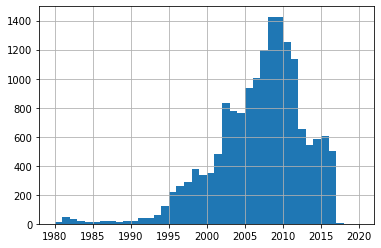

In [91]:
games_by_year = games_df.query('Year_of_Release > 0')
games_by_year['Year_of_Release'].hist(bins=40)

Сейчас гейм-индустря переживает спад - количество выпускаемых игр на уровне 2002 (около 500 в год). Да, пик 2008-2009 года уже позади, а тогда выходило больше 1400 игр в год. Значит конкуренция, возможно, не так высока....

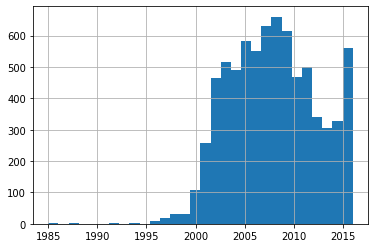

In [92]:
games_by_year_with_scores =  games_by_year.query('User_Score > 0')
games_by_year_without_scores =  games_by_year.query('User_Score == -1')
games_by_year_with_scores['Year_of_Release'].hist(bins=30)

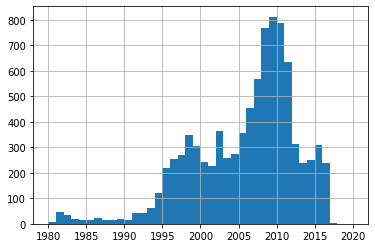

In [93]:
games_by_year_without_scores['Year_of_Release'].hist(bins=40)

Видно, что пользовательские оценки получают игры в основном после 2000 года выпуска.

### Рассмотрим продажи

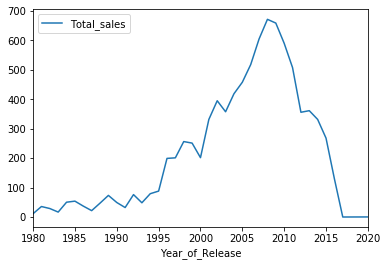

In [94]:
players_by_year = games_by_year.pivot_table(index='Year_of_Release', values='Total_sales', aggfunc=np.sum) 
players_by_year.plot()

Видно, что продажи неплохо коррелируют с количеством выпускаемых игр - чем больше игр выпускаем, тем больше и продаем (т.е пик продаж также приходится на 2008-2009 годы). При этом в последние годы продажи сильно упали (сильнее, чем выпуск игр). Это еще раз говорит, что отрасль в некотором кризисе. Конкуренция может быть не так сильна, но и пользователи достаточно требовательны.

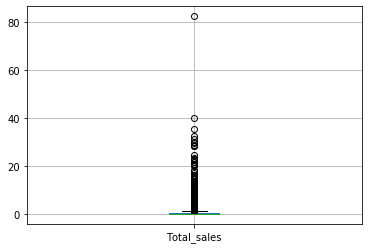

In [95]:
import matplotlib.pyplot as plt

games_df.boxplot(column=['Total_sales'])

In [96]:
print('Рассмотрим количества по группам:')
print('Лидеры рынка с продажами более 30 млн. долларов - ', games_df.query('Total_sales > 30').shape[0])
print('Сильные игры с продажамиот 10 до 30 млн. долларов -', games_df.query('10 < Total_sales <= 30').shape[0])
print('Уверенные середнечки с продажами от 1 до 10 млн. долларов -', games_df.query('1 < Total_sales <= 10').shape[0])
print('Отстающие с продажами более от 0.1 до 1 млн. долларов -', games_df.query('0.1 < Total_sales <= 1').shape[0])
print('Не удачные проекты, которые врядли окупились с продажами менее 0.1 млн.долларов -', games_df.query('Total_sales < 0.1').shape[0])

Рассмотрим количества по группам:
Лидеры рынка с продажами более 30 млн. долларов -  6
Сильные игры с продажамиот 10 до 30 млн. долларов - 56
Уверенные середнечки с продажами от 1 до 10 млн. долларов - 1999
Отстающие с продажами более от 0.1 до 1 млн. долларов - 8351
Не удачные проекты, которые врядли окупились с продажами менее 0.1 млн.долларов - 6095


Мы видим, что выпуск консольной игры - рискованный проект. Более 6095  игр из наших данных (а это 36%) скорее всего не покрыли затрат на разработку.По настоящему популярными стали всего 62 игры (менее 1%). Еще 12% игр принесли неплохую прибыль и 50% находятся где-то на грани окупаемости и небольшой прибыли (зависит, конечно, от затрат на разработку, но продажи в целом не впечатляют.)

### Рассмотрим различные консоли и жанры

In [97]:
games_platform = games_df['Platform'].value_counts().sort_values(ascending=False)
games_platform.head()

PS2     2161
DS      2152
PS3     1331
Wii     1320
X360    1262
Name: Platform, dtype: int64

In [98]:
games_platform = games_df['Genre'].value_counts().sort_values(ascending=False)
games_platform.head()

Action          3370
Sports          2348
Misc            1750
Role-Playing    1500
Shooter         1323
Name: Genre, dtype: int64

Больше всего игр было выпущено под PS2. Не удивительно, ведь эта платформа была распространена в период наиболее активного выпуска.продажи игр (2008-2009 год).

Жанр Action также оказался очень популярным у производителей ... 

In [99]:
players_by_genre = games_df.pivot_table(index='Genre', values='Total_sales', aggfunc=np.sum) 
players_by_genre.sort_values(by = 'Total_sales', ascending=False).head()

,Total_sales
Genre,
Action,1744.18
Sports,1331.27
Shooter,1052.45
Role-Playing,934.61
Platform,827.77


и у пользователей тоже. Также популярны шутеры и спортивные игры, они вмете с экшнами приносят больше всего дохода.

### Рассмотрим оценки пользователей и критиков

In [100]:
games_df.sort_values(by = 'User_Score', ascending=False).head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,RU_sales,Other_sales,Critic_Score,User_Score,Rating,Total_sales
14414,Breath of Fire III,PSP,2005,Role-Playing,0.00,0.02,0.00,0.01,-1.0,9.7,T,0.03
8976,Boktai: The Sun is in Your Hand,GBA,2003,Role-Playing,0.10,0.04,0.00,0.00,83.0,9.6,E,0.14
3417,Harvest Moon: Friends of Mineral Town,GBA,2003,Simulation,0.34,0.13,0.11,0.01,81.0,9.6,E,0.59
10106,Cory in the House,DS,2007,Action,0.10,0.00,0.00,0.01,-1.0,9.5,E,0.11
16550,Wade Hixton's Counter Punch,GBA,2004,Sports,0.01,0.00,0.00,0.00,78.0,9.5,T,0.01


In [101]:
games_df.query('User_Score > 0').sort_values(by = 'User_Score', ascending=True).head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,RU_sales,Other_sales,Critic_Score,User_Score,Rating,Total_sales
13683,Myth Makers: Trixie in Toyland,Wii,2008,Platform,0.04,0.00,0.0,0.00,-1.0,0.2,E,0.04
9971,Madden NFL 17,PS3,2016,Sports,0.07,0.02,0.0,0.02,-1.0,0.2,E,0.11
5764,Happy Feet,DS,2006,Action,0.27,0.01,0.0,0.02,-1.0,0.3,E,0.30
13381,Billy the Wizard: Rocket Broomstick Racing,Wii,2007,Racing,0.04,0.00,0.0,0.00,-1.0,0.3,E,0.04
10263,Charlie and the Chocolate Factory,XB,2005,Adventure,0.08,0.02,0.0,0.00,39.0,0.5,E,0.10


In [102]:
games_df.sort_values(by = 'Critic_Score', ascending=False).head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,RU_sales,Other_sales,Critic_Score,User_Score,Rating,Total_sales
5350,SoulCalibur,DC,1999,Fighting,0.00,0.00,0.34,0.00,98.0,8.8,T,0.34
227,Tony Hawk's Pro Skater 2,PS,2000,Sports,3.05,1.41,0.02,0.20,98.0,7.7,T,4.68
57,Grand Theft Auto IV,PS3,2008,Action,4.76,3.69,0.44,1.61,98.0,7.5,M,10.50
51,Grand Theft Auto IV,X360,2008,Action,6.76,3.07,0.14,1.03,98.0,7.9,M,11.00
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05


In [103]:
games_df.query('Critic_Score > 0').sort_values(by = 'Critic_Score', ascending=True).head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,RU_sales,Other_sales,Critic_Score,User_Score,Rating,Total_sales
13690,Ride to Hell,PS3,2013,Racing,0.02,0.01,0.0,0.01,13.0,1.0,M,0.04
10663,Leisure Suit Larry: Box Office Bust,PS3,2009,Adventure,0.06,0.03,0.0,0.01,17.0,1.7,M,0.10
12823,Ride to Hell,X360,2013,Racing,0.04,0.01,0.0,0.01,19.0,1.3,M,0.06
10016,Rugby 15,PS4,2015,Sports,0.04,0.06,0.0,0.02,19.0,3.4,E,0.12
15345,Balls of Fury,Wii,2007,Sports,0.02,0.00,0.0,0.00,19.0,2.8,E10+,0.02


Видим, что лидеры пользователей и критиков разнятся. Есть ли корреляция между оценками пользователей и критиков?

In [104]:
print(games_df ['Critic_Score'].corr(games_df ['User_Score']))

0.8190127521775864


In [105]:
games_with_scores = games_df.query('Critic_Score > 0 and User_Score > 0')
print(games_with_scores ['Critic_Score'].corr(games_with_scores  ['User_Score']))

0.5808778320767236


Казалось, что существует весьма сильная положительная корреляция. Т.е. у игр с высокой оценкой критиков и оценка пользователей вероятно тоже будет высока.

Однако, когда мы убрали игры без оценок, то коэффициент корреляции упал. Теперь можно сказать, что связь есть но не столь сильная. Значит, если критики поставили высокую оценку игре она имеет достаточно хорошие шансы понравиться пользователям, однако, это не гарантировано.

## Шаг 3. Анализ по регионам.

#### Северная Америка

In [106]:
players_by_genre_NA = games_df.pivot_table(index='Genre', values='NA_sales', aggfunc=np.sum) 
players_by_genre_NA.sort_values(by = 'NA_sales', ascending=False).head()

,NA_sales
Genre,
Action,879.01
Sports,684.43
Shooter,592.24
Platform,445.50
Misc,407.27


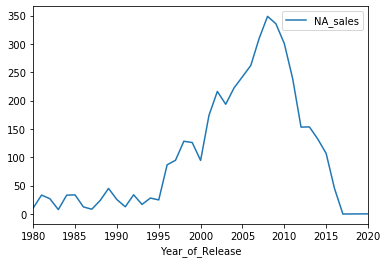

In [107]:
players_by_year_NA = games_by_year.pivot_table(index='Year_of_Release', values='NA_sales', aggfunc=np.sum) 
players_by_year_NA.plot()

In [108]:
players_by_platform_NA = games_df.pivot_table(index='Platform', values='NA_sales', aggfunc=np.sum) 
players_by_platform_NA.sort_values(by = 'NA_sales', ascending=False).head()

,NA_sales
Platform,
X360,602.47
PS2,583.84
Wii,496.90
PS3,393.49
DS,382.67


#### Европа

In [109]:
players_by_genre_EU = games_df.pivot_table(index='Genre', values='EU_sales', aggfunc=np.sum) 
players_by_genre_EU.sort_values(by = 'EU_sales', ascending=False).head()

,EU_sales
Genre,
Action,519.13
Sports,376.79
Shooter,317.34
Racing,236.51
Misc,212.74


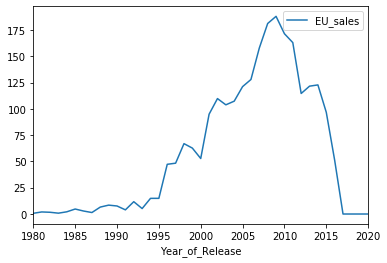

In [110]:
players_by_year_EU = games_by_year.pivot_table(index='Year_of_Release', values='EU_sales', aggfunc=np.sum) 
players_by_year_EU.plot()

In [111]:
players_by_platform_EU = games_df.pivot_table(index='Platform', values='EU_sales', aggfunc=np.sum) 
players_by_platform_EU.sort_values(by = 'EU_sales', ascending=False).head()

,EU_sales
Platform,
PS2,339.29
PS3,330.29
X360,270.76
Wii,262.21
PS,213.61


#### Россия

In [112]:
players_by_genre_RU = games_df.pivot_table(index='Genre', values='RU_sales', aggfunc=np.sum) 
players_by_genre_RU.sort_values(by = 'RU_sales', ascending=False).head()

,RU_sales
Genre,
Role-Playing,355.46
Action,161.44
Sports,135.54
Platform,130.83
Misc,108.11


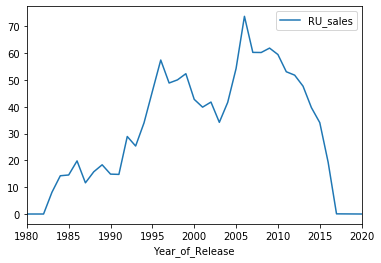

In [113]:
players_by_year_RU = games_by_year.pivot_table(index='Year_of_Release', values='RU_sales', aggfunc=np.sum) 
players_by_year_RU.plot()

In [114]:
players_by_platform_RU = games_df.pivot_table(index='Platform', values='RU_sales', aggfunc=np.sum) 
players_by_platform_RU.sort_values(by = 'RU_sales', ascending=False).head()

,RU_sales
Platform,
DS,175.57
PS,139.82
PS2,139.20
SNES,116.55
3DS,100.67


Здесь видно, что европейский и американский рынки очень схожи: и лидирующие жанры и график продаж практически идентичны, небольшие различия есть только в предпочитаемых платформах (в Америке лидирует XBOX, в то время как в Европе  - PS). Одновременно с этим, на Российским ранке ситуация сильно отличается. 

Таким образом, если мы ориентируемся на внутренний рынок, то стоит рассмотреть жанр RPG и платформу Nintendo, а если рассмотриваем глобальные рынки, то предпочтительным будет Action и платформы XBOX и PlayStation.

In [115]:
games_df['Rating'].value_counts()

RP      6772
E       3991
T       2961
M       1563
E10+    1420
EC         8
K-A        3
AO         1
Name: Rating, dtype: int64

Больше всего игр с рейтингом - это игры без ограничений (Для всех) и для подростков 13-19 лет. Что ж целевая аудитория вполне понятна...

## Шаг 4. Проверка гипотез.

#### Первая гипотеза. Средний пользовательский рейтинг платформ PS2 и PS3 одинаковый.

Обозначим среднии пользовательский рейтинг М2 и М3 соответственно, тогда:

нулевая гипотеза Н0: М2=М3

альтернативная гипотеза На: М2!=М3 (двухсторонняя альтернатива)

In [116]:
from scipy import stats as st
# выделим пользовательский рейтинг для PS2 и PS 3
ps2_users_score = games_df.query('User_Score > 0 and Platform == "PS2"')['User_Score']
ps3_users_score = games_df.query('User_Score > 0 and Platform == "PS3"')['User_Score']

# установим уровень значимости
alpha = .05

# выборки независимые, поэтому
hipotest = st.ttest_ind(
    ps2_users_score , 
    ps3_users_score)

print('p-значение: ', hipotest.pvalue)

if (hipotest.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  1.5742610791426753e-47
Отвергаем нулевую гипотезу


#### Вторая гипотеза. Средний пользовательский рейтинг жанров Action и Sports различается.

Обозначим среднии пользовательский рейтинг МA и МS соответственно, тогда:

нулевая гипотеза Н0: МA=МS

альтернативная гипотеза На: МA!=МS (двухсторонняя альтернатива)

In [117]:
# выделим пользовательский рейтинг для PS2 и PS 3
action_users_score = games_df.query('User_Score > 0 and Genre == "Action"')['User_Score']
sports_users_score = games_df.query('User_Score > 0 and Genre == "Sports"')['User_Score']

# установим уровень значимости
alpha = .05

# выборки независимые, поэтому
hipotest = st.ttest_ind(
    action_users_score , 
    sports_users_score)

print('p-значение: ', hipotest.pvalue)

if (hipotest.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.10406951359049141
Не получилось отвергнуть нулевую гипотезу


# Выводы

- рынок консольных игр переживает крисив - выпуск игр упал с рекордных показателей 2008-2009 годов (более 1400 игр в год), до значения менее 500 игр в прошлом году. Одновременно с этим упали и продажи  - от почти 672 млн. долларов в 2008, до 130 млн. в 2016.

- выпуск консольных игр - рискованный проект. Только 13% игр приносят ощутимую прибыль, при этом 36% не окупаются.

- cамыми популярными жанрами по всему миру являются Action, Sport и Shooter, российский рынок при этом уникальный и самыми опулярными являются RPG.

- больше всего игр с рейтингом - это игры без ограничений (Для всех) и для подростков 13-19 лет. Т.е. игра должна быть нацелена либо на массового пользователя, либо на подростковую аудиторию - остальное нишевый продукт.

- существует прямая зависимость между оценкой критиков и оценкой пользователей, однако, она не слишком сильная. (r = 0.58)

-  пользовательский рейтинг игр на PS2 в среднем выше, чем игр PS3.

-  нельзя сказать, что средний пользовательский рейтинг у популярных жанров Action и Sports отличается.